In [32]:
from SafeTransformer import SafeTransformer
from sklearn.base import BaseEstimator, TransformerMixin

import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

from copy import deepcopy

In [7]:
diabetes = pd.read_csv("diabetes.csv")
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [9]:
y = diabetes["Outcome"]
X = diabetes.drop(["Outcome"], axis=1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

# SAFE

In [43]:
tree_model = DecisionTreeClassifier(random_state=123)
tree_model = tree_model.fit(X_train, y_train)
standard_predictions = tree_model.predict(X_test)
print(accuracy_score(y_test, standard_predictions))

0.703125


In [66]:
surrogate_model = XGBClassifier(eval_metric = 'auc', random_state = 123,
    subsample = 1.0, n_estimators = 300, min_child_weight = 17, max_depth = 3, 
    learning_rate = 0.1, gamma = 1)
surrogate_model = surrogate_model.fit(X_train, y_train)
surrogate_model_predictions = surrogate_model.predict(X_test)
print(accuracy_score(y_test, surrogate_model_predictions))

0.8125


In [70]:
pens = range(1, 10)
best_score = float('-Inf')
best_pen = 0
aucs = []

for pen in pens:
    surrogate_model = XGBClassifier(eval_metric = 'auc', random_state = 123,
    subsample = 1.0, n_estimators = 300, min_child_weight = 17, max_depth = 3, 
    learning_rate = 0.1, gamma = 1)
    tree_model_simple = DecisionTreeClassifier(random_state=123)
    safe_transformer = SafeTransformer(surrogate_model, penalty = pen)
    pipe = Pipeline(steps=[('safe', safe_transformer), ('tree', tree_model_simple)])
    pipe = pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    auc = accuracy_score(y_test, predictions)
    aucs.append(auc)
    print([pen,auc])
    if auc > best_score:
        best_transformer = deepcopy(safe_transformer)
        best_model = deepcopy(tree_model_simple)
        best_score = auc
        best_pen = pen

[1, 0.765625]
[2, 0.78125]
[3, 0.78125]
[4, 0.78125]
[5, 0.78125]
[6, 0.75]
[7, 0.75]
[8, 0.75]
[9, 0.75]


In [73]:
best_score

0.78125

# Plot

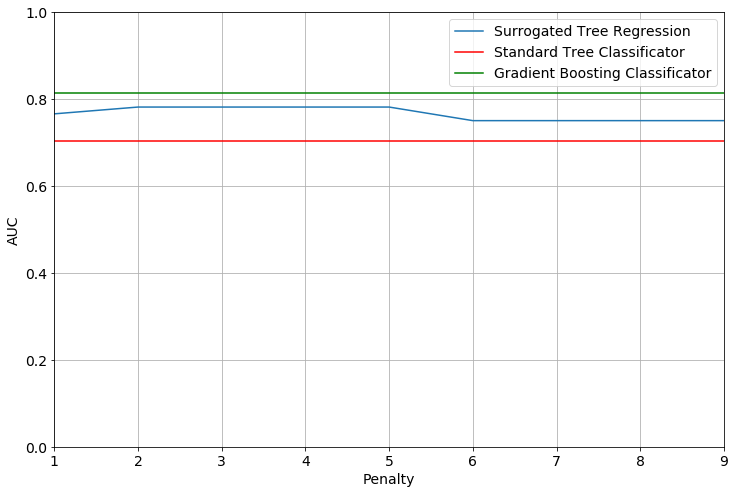

In [72]:
standard_auc = accuracy_score(y_test, standard_predictions)
xgb_auc = accuracy_score(y_test, surrogate_model_predictions)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 14})
plt.plot(pens[0:], aucs[0:], label='Surrogated Tree Regression')
plt.xlabel('Penalty')
plt.ylabel('AUC')
plt.grid(True)
plt.axhline(standard_auc, color='r', label='Standard Tree Classificator')
plt.axhline(xgb_auc, color='g', label='Gradient Boosting Classificator')
plt.ylim((0, 1))
plt.xlim((1,max(pens)))
plt.legend()
plt.show()